In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [21]:
# Define global params for training
LEARNING_RATE = 0.01
EPOCHS = 50
EMBEDDING_SIZE = 50
DEBUG_LENGTH = 10
HIDDEN_SIZE = 100
UNIQUE_WORDS = 2000

DEBUG = True

In [3]:
SOS_token = 1
EOS_token = 2

In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points, points2):
#     plt.figure()
#     fig, ax = plt.subplots()
#     # this locator puts ticks at regular intervals
#     loc = ticker.MultipleLocator(base=1)
#     ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.plot(points2)
    plt.show()

# Load dataset

In [5]:
def load_dataset(language):
    with open('data/train.{}.txt'.format(language), 'r') as data:
        sentences = [sentence.rstrip('\n').split(' ') for sentence in data]
    with open('data/vocab.{}.txt'.format(language), 'r') as vocab:
        vocab = {word.rstrip('\n'): index for index, word in enumerate(vocab)}
    return sentences, vocab

en_sentences, en_vocab = load_dataset('en')
vi_sentences, vi_vocab = load_dataset('vi')

dataset = list(zip(en_sentences, vi_sentences))

In [6]:
def create_vocab(sentences):
    language_dict = dict()
    for sentence in sentences:
        for word in sentence:
            if word in language_dict:
                language_dict[word] += 1
            else:
                language_dict[word] = 1
    word_frequency = [(word, language_dict[word]) for word in language_dict]
    sorted_word_frequency = sorted(word_frequency, key=lambda x: x[1], reverse=True)
    if len(sorted_word_frequency) > UNIQUE_WORDS - 3:
        sorted_word_frequency = sorted_word_frequency[:UNIQUE_WORDS - 3]
    new_dict = {'<unk>': 0, '<s>': 1, '</s>': 2}
    counter = 3
    for word_tuple in sorted_word_frequency:
        if word_tuple[0] not in new_dict:
            new_dict[word_tuple[0]] = counter
            counter += 1
    return new_dict

en_vocab = create_vocab(en_sentences)
vi_vocab = create_vocab(vi_sentences)

In [7]:
def load_test_sets(in_language, out_language):
    with open('data/test.{}.txt'.format(in_language), 'r') as data:
        in_sentences = [sentence.rstrip('\n').split(' ') for sentence in data]
    with open('data/test.{}.txt'.format(out_language), 'r') as data:
        out_sentences = [sentence.rstrip('\n').split(' ') for sentence in data]
    return in_sentences, out_sentences

en_test_sentences, vi_test_sentences = load_test_sets('en', 'vi')

# Process dataset

In [8]:
def word_from_dict(word, lan_dict):
    if word in lan_dict:
        return lan_dict[word]
    else:
        return lan_dict['<unk>']

def process_sentences(sentences, vocab, translate_to=False):
    X = list()
    Xoh = list()
    for index, sentence in enumerate(sentences):
        if translate_to:
            index_sentence = [SOS_token] + [word_from_dict(word, vocab) for word in sentence] + [EOS_token]
        else:
            index_sentence = [word_from_dict(word, vocab) for word in sentence] + [EOS_token]
        a = np.array(index_sentence)
        b = np.zeros((a.size, len(vocab)))
        b[np.arange(a.size),a] = 1
        X.append(index_sentence)
        Xoh.append(b)
    X = np.array([np.array(Xi) for Xi in X])
    Xoh = np.array([Xohi for Xohi in Xoh])
    return X, Xoh

In [9]:
X, Xoh = process_sentences(en_sentences, en_vocab)

In [10]:
Y, Yoh = process_sentences(vi_sentences, vi_vocab, translate_to=True)

In [11]:
X_test, Xoh_test = process_sentences(en_test_sentences, en_vocab)

In [12]:
Y_test, Yoh_test = process_sentences(vi_test_sentences, vi_vocab, translate_to=True)

# Build model

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, EMBEDDING_SIZE)
        self.gru = nn.GRU(EMBEDDING_SIZE, hidden_size, bidirectional=True, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(2, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [14]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 3, 1)

    def forward(self, decoder_hidden, encoder_output):
        decoder_hidden_expanded = decoder_hidden.expand(1, encoder_output.size()[1], decoder_hidden.size()[2])
        input_vector = torch.cat((decoder_hidden_expanded, encoder_output), 2)
        output = torch.matmul(input_vector, self.attn.weight.t())
        attn_weights = F.softmax(output, dim=1)
        permuted_encoder_output = encoder_output.permute(0, 2, 1)
        input_context = torch.bmm(permuted_encoder_output, attn_weights).view(1,1,-1)
        return input_context

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, EMBEDDING_SIZE)
        self.gru = nn.GRU(self.hidden_size * 2 + EMBEDDING_SIZE, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, input_size)

    def forward(self, input_context, hidden, word):
        embedded = self.embedding(word)
        output = torch.cat((embedded, input_context), 2)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        output = F.log_softmax(output, dim=2)
        return output, hidden

In [16]:
def train_step(in_sentence, out_sentence, model_sections, optimizing_params):
    # pass input sentence through encoder
    encoder_hidden = encoder.initHidden()
    input = Variable(torch.LongTensor(in_sentence).view(1,-1))
    input = input.cuda() if use_cuda else input
    encoder_output, encoder_hidden = model_sections['encoder'](input, encoder_hidden)
    
    # initialize decoder hidden layer with final encoder hidden layer
    decoder_hidden = encoder_hidden[0].clone().view(1,1,-1)
    
    # initialize loss to 0
    loss = 0 
    
    # pass encoder output through attention + decoder
    for word_index in out_sentence:
        decoder_input = Variable(torch.LongTensor([[int(word_index)]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        input_context = model_sections['attention'](decoder_hidden, encoder_output) 
        decoder_output, decoder_hidden = model_sections['decoder'](input_context, decoder_hidden, decoder_input)
        loss += optimizing_params['loss_function'](decoder_output.view(1,-1), decoder_input.view(-1))
    loss.backward()
    optimizing_params['enc_optimizer'].step()
    optimizing_params['att_optimizer'].step()
    optimizing_params['dec_optimizer'].step()
    
    return loss.data[0] / len(out_sentence)

In [17]:
def test_step(in_sentence, out_sentence, model_sections, optimizing_params):
    # pass input sentence through encoder
    encoder_hidden = encoder.initHidden()
    input = Variable(torch.LongTensor(in_sentence).view(1,-1))
    input = input.cuda() if use_cuda else input
    encoder_output, encoder_hidden = model_sections['encoder'](input, encoder_hidden)
    
    # initialize decoder hidden layer with final encoder hidden layer
    decoder_hidden = encoder_hidden[0].clone().view(1,1,-1)
    
    # initialize loss to 0
    loss = 0 
    
    # pass encoder output through attention + decoder
    for word_index in out_sentence:
        decoder_input = Variable(torch.LongTensor([[int(word_index)]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        input_context = model_sections['attention'](decoder_hidden, encoder_output) 
        decoder_output, decoder_hidden = model_sections['decoder'](input_context, decoder_hidden, decoder_input)
        loss += optimizing_params['loss_function'](decoder_output.view(1,-1), decoder_input.view(-1))
    return loss.data[0] / len(out_sentence)

In [34]:
def train(in_sentences, out_sentences, in_test_sentences, out_test_sentences, model_sections, optimizing_params):
    training_losses = list()
    testing_losses = list()
    current_loss = 0
    testing_loss = 0
    for epoch_num in range(EPOCHS):
        if DEBUG:
            train_set_length = DEBUG_LENGTH
            test_set_length = DEBUG_LENGTH
        else:
            train_set_length = len(in_sentences)
            test_set_length = len(in_test_sentences)
        for in_sentence, out_sentence in zip(in_sentences[:train_set_length], out_sentences[:train_set_length]):
            current_loss += train_step(in_sentence, out_sentence, model_sections, optimizing_params)
        for in_test_sentence, out_test_sentence in zip(in_test_sentences[:test_set_length], out_test_sentences[:test_set_length]):
            testing_loss += test_step(in_test_sentence, out_test_sentence, model_sections, optimizing_params)
               
        print('Epoch: {} | TRAINING Loss: {} | TESTING Loss: {}'.format(epoch_num + 1, current_loss / train_set_length, testing_loss / test_set_length))
        training_losses.append(current_loss / train_set_length)
        testing_losses.append(testing_loss  / test_set_length)
        current_loss = 0
        testing_loss = 0
    return training_losses, testing_losses

In [35]:
# Instantiate model and optimizer
encoder = EncoderRNN(len(en_vocab), HIDDEN_SIZE)
attention = Attention(HIDDEN_SIZE)
decoder = DecoderRNN(len(vi_vocab), HIDDEN_SIZE)
criterion = nn.NLLLoss()
encoder_optimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
attention_optimizer = optim.SGD(attention.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)

# save model and optimizer params to dict
model_sections = {'encoder': encoder, 
                  'attention': attention, 
                  'decoder': decoder,
                 }

optimizing_params = {'loss_function': criterion, 
                     'enc_optimizer': encoder_optimizer,
                     'att_optimizer': attention_optimizer,
                     'dec_optimizer': decoder_optimizer,
                    }

In [36]:
training_losses, testing_losses = train(X, Y, X_test, Y_test, model_sections, optimizing_params)

Epoch: 1 | TRAINING Loss: 7.041870692253542 | TESTING Loss: 6.0529797361111495
Epoch: 2 | TRAINING Loss: 3.769784379490205 | TESTING Loss: 5.611906244803806
Epoch: 3 | TRAINING Loss: 2.1109667264369496 | TESTING Loss: 5.562807493304687
Epoch: 4 | TRAINING Loss: 0.9091241586921562 | TESTING Loss: 7.443461373722774
Epoch: 5 | TRAINING Loss: 0.9923537748990379 | TESTING Loss: 10.015064811790586
Epoch: 6 | TRAINING Loss: 3.2872420182343687 | TESTING Loss: 13.634627021564672
Epoch: 7 | TRAINING Loss: 3.1819766628423145 | TESTING Loss: 12.718148345347123
Epoch: 8 | TRAINING Loss: 5.025639607048335 | TESTING Loss: 19.91256579191326
Epoch: 9 | TRAINING Loss: 13.592446564740015 | TESTING Loss: 26.67644702985819
Epoch: 10 | TRAINING Loss: 18.285023211038602 | TESTING Loss: 35.08686170985578
Epoch: 11 | TRAINING Loss: 19.32296846974502 | TESTING Loss: 39.76358575306772
Epoch: 12 | TRAINING Loss: 16.727240959773233 | TESTING Loss: 44.26124536231953
Epoch: 13 | TRAINING Loss: 14.874220794166362 | T

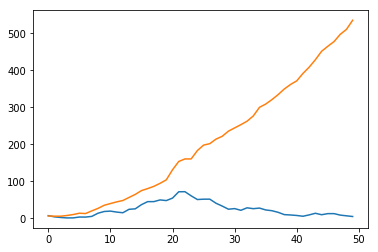

In [40]:
showPlot(training_losses, testing_losses)